In [45]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [15]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


In [16]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [17]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [18]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [19]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [20]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [21]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [22]:
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, IMAGE_SIZE)
    return img

In [23]:
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [24]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [51]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

## Step1. 실험환경 set-up

In [25]:
BATCH_SIZE = 64
EPOCHS = 50

## Step 2. 데이터 준비하기

In [26]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [27]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## Step 3. 데이터 시각화

In [28]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE//4):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/16),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

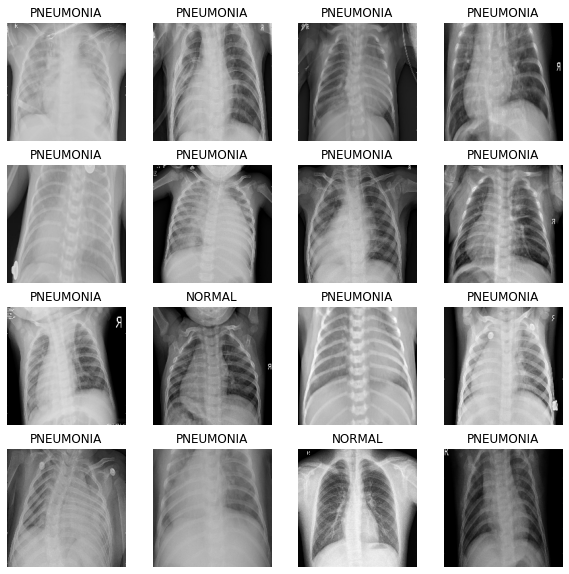

In [29]:
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## Step 4. CNN 모델링

### 1. Convolution filter, 채널 개수, activation, 모델 구조 변경

In [30]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation = 'relu', padding = 'same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation = 'relu', padding = 'same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [31]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation = 'relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [32]:
def build_model():
    model = Sequential([
        Input(shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        Conv2D(16, 3, activation = 'relu', padding = 'same'),
        Conv2D(32, 3, activation = 'relu', padding = 'same'),
        MaxPool2D(),
        
        conv_block(64),
        conv_block(128),
        Dropout(0.3),
        
        conv_block(128),
        conv_block(256),
        Dropout(0.3),
        
        conv_block(256),
        conv_block(512),
        Dropout(0.3),
        
        Flatten(),
        dense_block(1024, 0.6),
        dense_block(256, 0.4),
        dense_block(64, 0.2),
        
        Dense(1, activation = 'sigmoid')
        
    ])
    
    return model

### 2. BatchNorm만 사용

In [33]:
def conv_batch_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation = 'relu', padding = 'same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation = 'relu', padding = 'same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [34]:
def dense_batch_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation = 'relu'),
        tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [35]:
def build_batch_model():
    model = Sequential([
        Input(shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        Conv2D(16, 3, activation = 'relu', padding = 'same'),
        Conv2D(16, 3, activation = 'relu', padding = 'same'),
        MaxPool2D(),
        
        conv_batch_block(32),
        conv_batch_block(64),
        
        conv_batch_block(128),
#         Dropout(0.2),
        
        conv_batch_block(256),
#         Dropout(0.2),
        
        Flatten(),
        dense_batch_block(512, 0.7),
        dense_batch_block(128, 0.5),
        dense_batch_block(64, 0.3),
        
        Dense(1, activation = 'sigmoid')
        
    ])
    
    return model

### 3. Dropout만 사용

In [36]:
def conv_drop_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation = 'relu', padding = 'same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation = 'relu', padding = 'same'),
#         tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [37]:
def dense_drop_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation = 'relu'),
#         tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [38]:
def build_drop_model():
    model = Sequential([
        Input(shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        Conv2D(16, 3, activation = 'relu', padding = 'same'),
        Conv2D(16, 3, activation = 'relu', padding = 'same'),
        MaxPool2D(),
        
        conv_drop_block(32),
        conv_drop_block(64),
        
        conv_drop_block(128),
        Dropout(0.2),
        
        conv_drop_block(256),
        Dropout(0.2),
        
        Flatten(),
        dense_drop_block(512, 0.7),
        dense_drop_block(128, 0.5),
        dense_drop_block(64, 0.3),
        
        Dense(1, activation = 'sigmoid')
        
    ])
    
    return model

## Step 5. 데이터 imbalance 처리

Class Weight 생략버전과 설정 버전 비교

In [39]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


## Step 6. 모델 훈련, Step 7. 결과 확인과 시각화

### 1. Convolution filter, 채널 개수, activation, 모델 구조 변경

With Weight

In [46]:
with tf.device('/GPU:0'):
    model = build_model()
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name = 'precision'),
        tf.keras.metrics.Recall(name = 'recall')
    ]
    
    model.compile(
        optimizer = 'Rmsprop',
        loss = 'binary_crossentropy',
        metrics = METRICS
    )

In [58]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/50
65/65 [==============================] - 58s 741ms/step - loss: 0.7268 - accuracy: 0.6094 - precision: 0.8323 - recall: 0.5948 - val_loss: 0.6184 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 2/50
65/65 [==============================] - 48s 743ms/step - loss: 0.2638 - accuracy: 0.8974 - precision: 0.9711 - recall: 0.8887 - val_loss: 0.6082 - val_accuracy: 0.7314 - val_precision: 0.7314 - val_recall: 1.0000
Epoch 3/50
65/65 [==============================] - 49s 755ms/step - loss: 0.1672 - accuracy: 0.9389 - precision: 0.9797 - recall: 0.9372 - val_loss: 0.6436 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 4/50
65/65 [==============================] - 51s 786ms/step - loss: 0.1476 - accuracy: 0.9450 - precision: 0.9793 - recall: 0.9461 - val_loss: 0.8808 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 5/50
65/65 [==============================] - 60s 939ms/step - loss: 0.1368 - accuracy: 0.9517

65/65 [==============================] - 46s 715ms/step - loss: 0.0282 - accuracy: 0.9909 - precision: 0.9974 - recall: 0.9903 - val_loss: 0.1733 - val_accuracy: 0.9609 - val_precision: 0.9507 - val_recall: 0.9987
Epoch 38/50
65/65 [==============================] - 47s 728ms/step - loss: 0.0321 - accuracy: 0.9882 - precision: 0.9951 - recall: 0.9890 - val_loss: 0.5508 - val_accuracy: 0.9131 - val_precision: 1.0000 - val_recall: 0.8826
Epoch 39/50
65/65 [==============================] - 60s 926ms/step - loss: 0.0203 - accuracy: 0.9928 - precision: 0.9987 - recall: 0.9916 - val_loss: 0.0733 - val_accuracy: 0.9824 - val_precision: 0.9973 - val_recall: 0.9788
Epoch 40/50
65/65 [==============================] - 47s 725ms/step - loss: 0.0199 - accuracy: 0.9940 - precision: 0.9977 - recall: 0.9942 - val_loss: 0.3381 - val_accuracy: 0.9229 - val_precision: 1.0000 - val_recall: 0.8951
Epoch 41/50
65/65 [==============================] - 46s 718ms/step - loss: 0.0276 - accuracy: 0.9909 - prec

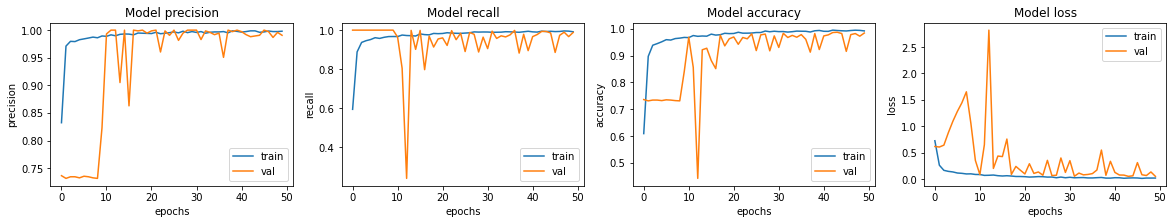

In [59]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [60]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

10/10 [==============================] - 4s 384ms/step - loss: 1.6010 - accuracy: 0.7228 - precision: 0.6927 - recall: 1.0000
Loss: 1.6010428667068481,
Accuracy: 0.7227563858032227,
Precision: 0.6927176117897034,
Recall: 1.0


Without Weight

In [61]:
with tf.device('/GPU:0'):
    model = build_model()
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name = 'precision'),
        tf.keras.metrics.Recall(name = 'recall')
    ]
    
    model.compile(
        optimizer = 'Rmsprop',
        loss = 'binary_crossentropy',
        metrics = METRICS
    )

In [62]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
#         class_weight=class_weight,
    )

Epoch 1/50
65/65 [==============================] - 60s 761ms/step - loss: 0.7929 - accuracy: 0.5582 - precision: 0.7483 - recall: 0.6114 - val_loss: 0.6207 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 2/50
65/65 [==============================] - 49s 753ms/step - loss: 0.3263 - accuracy: 0.8760 - precision: 0.9430 - recall: 0.8869 - val_loss: 0.6374 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 3/50
65/65 [==============================] - 49s 762ms/step - loss: 0.2512 - accuracy: 0.9084 - precision: 0.9389 - recall: 0.9380 - val_loss: 0.6254 - val_accuracy: 0.7373 - val_precision: 0.7373 - val_recall: 1.0000
Epoch 4/50
65/65 [==============================] - 51s 785ms/step - loss: 0.1685 - accuracy: 0.9385 - precision: 0.9547 - recall: 0.9627 - val_loss: 0.9835 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 5/50
65/65 [==============================] - 53s 825ms/step - loss: 0.1429 - accuracy: 0.9490

65/65 [==============================] - 47s 733ms/step - loss: 0.0231 - accuracy: 0.9921 - precision: 0.9949 - recall: 0.9946 - val_loss: 0.1034 - val_accuracy: 0.9795 - val_precision: 0.9973 - val_recall: 0.9748
Epoch 38/50
65/65 [==============================] - 46s 716ms/step - loss: 0.0260 - accuracy: 0.9933 - precision: 0.9948 - recall: 0.9961 - val_loss: 0.1229 - val_accuracy: 0.9639 - val_precision: 0.9945 - val_recall: 0.9563
Epoch 39/50
65/65 [==============================] - 46s 718ms/step - loss: 0.0186 - accuracy: 0.9933 - precision: 0.9968 - recall: 0.9942 - val_loss: 0.1854 - val_accuracy: 0.9619 - val_precision: 0.9958 - val_recall: 0.9522
Epoch 40/50
65/65 [==============================] - 46s 714ms/step - loss: 0.0155 - accuracy: 0.9935 - precision: 0.9958 - recall: 0.9954 - val_loss: 0.1483 - val_accuracy: 0.9688 - val_precision: 0.9986 - val_recall: 0.9589
Epoch 41/50
65/65 [==============================] - 47s 722ms/step - loss: 0.0191 - accuracy: 0.9933 - prec

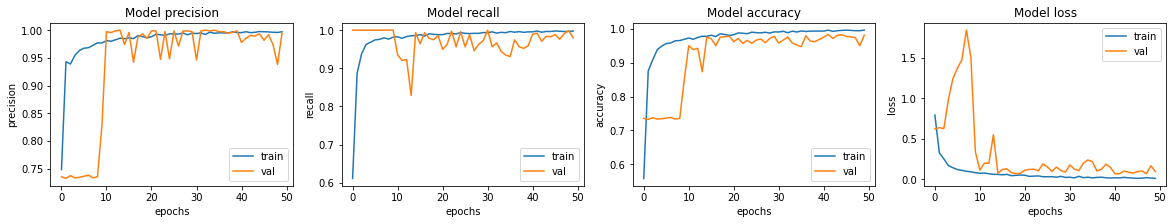

In [63]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [64]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

10/10 [==============================] - 4s 411ms/step - loss: 1.2354 - accuracy: 0.8173 - precision: 0.7794 - recall: 0.9872
Loss: 1.2353757619857788,
Accuracy: 0.817307710647583,
Precision: 0.7793522477149963,
Recall: 0.9871794581413269


### 2. BatchNorm만 사용

with weights

In [66]:
with tf.device('/GPU:0'):
    model = build_batch_model()
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name = 'precision'),
        tf.keras.metrics.Recall(name = 'recall')
    ]
    
    model.compile(
        optimizer = 'Adam',
        loss = 'binary_crossentropy',
        metrics = METRICS
    )

In [67]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/50
65/65 [==============================] - 56s 709ms/step - loss: 0.2283 - accuracy: 0.9038 - precision: 0.9720 - recall: 0.8965 - val_loss: 0.5781 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 2/50
65/65 [==============================] - 47s 731ms/step - loss: 0.1118 - accuracy: 0.9630 - precision: 0.9897 - recall: 0.9602 - val_loss: 0.6363 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 3/50
65/65 [==============================] - 47s 725ms/step - loss: 0.1097 - accuracy: 0.9635 - precision: 0.9868 - recall: 0.9638 - val_loss: 0.6926 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 4/50
65/65 [==============================] - 49s 755ms/step - loss: 0.0971 - accuracy: 0.9642 - precision: 0.9881 - recall: 0.9635 - val_loss: 0.7634 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 5/50
65/65 [==============================] - 52s 804ms/step - loss: 0.0825 - accuracy: 0.9695

65/65 [==============================] - 44s 681ms/step - loss: 0.0185 - accuracy: 0.9954 - precision: 0.9984 - recall: 0.9955 - val_loss: 0.3131 - val_accuracy: 0.9346 - val_precision: 0.9985 - val_recall: 0.9125
Epoch 38/50
65/65 [==============================] - 44s 690ms/step - loss: 0.0264 - accuracy: 0.9909 - precision: 0.9977 - recall: 0.9899 - val_loss: 0.1183 - val_accuracy: 0.9648 - val_precision: 0.9945 - val_recall: 0.9574
Epoch 39/50
65/65 [==============================] - 45s 691ms/step - loss: 0.0120 - accuracy: 0.9950 - precision: 0.9994 - recall: 0.9939 - val_loss: 0.2502 - val_accuracy: 0.9121 - val_precision: 0.8950 - val_recall: 0.9973
Epoch 40/50
65/65 [==============================] - 44s 685ms/step - loss: 0.0256 - accuracy: 0.9909 - precision: 0.9971 - recall: 0.9906 - val_loss: 0.2012 - val_accuracy: 0.9492 - val_precision: 0.9958 - val_recall: 0.9349
Epoch 41/50
65/65 [==============================] - 45s 701ms/step - loss: 0.0360 - accuracy: 0.9868 - prec

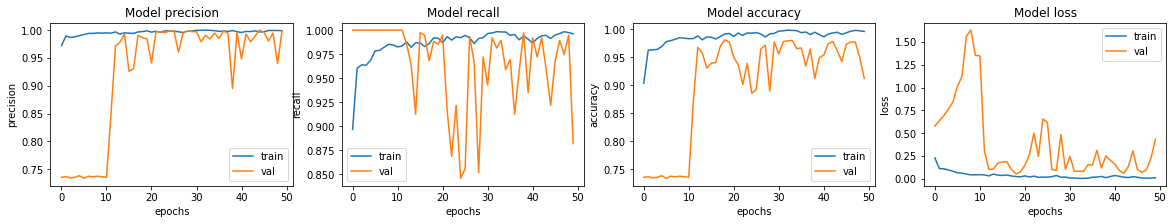

In [68]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [69]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

10/10 [==============================] - 5s 479ms/step - loss: 0.7051 - accuracy: 0.8510 - precision: 0.8817 - recall: 0.8795
Loss: 0.7050574421882629,
Accuracy: 0.8509615659713745,
Precision: 0.8817480802536011,
Recall: 0.879487156867981


# ACC 85%!!

without weights

In [70]:
with tf.device('/GPU:0'):
    model = build_batch_model()
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name = 'precision'),
        tf.keras.metrics.Recall(name = 'recall')
    ]
    
    model.compile(
        optimizer = 'Adam',
        loss = 'binary_crossentropy',
        metrics = METRICS
    )

In [71]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
#         class_weight=class_weight,
    )

Epoch 1/50
65/65 [==============================] - 56s 723ms/step - loss: 0.2130 - accuracy: 0.9317 - precision: 0.9731 - recall: 0.9342 - val_loss: 0.6084 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 2/50
65/65 [==============================] - 47s 723ms/step - loss: 0.1196 - accuracy: 0.9608 - precision: 0.9744 - recall: 0.9728 - val_loss: 0.5809 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 3/50
65/65 [==============================] - 48s 740ms/step - loss: 0.0894 - accuracy: 0.9702 - precision: 0.9778 - recall: 0.9823 - val_loss: 0.6279 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 4/50
65/65 [==============================] - 49s 757ms/step - loss: 0.0672 - accuracy: 0.9798 - precision: 0.9877 - recall: 0.9851 - val_loss: 0.7755 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 5/50
65/65 [==============================] - 51s 786ms/step - loss: 0.0686 - accuracy: 0.9755

65/65 [==============================] - 44s 678ms/step - loss: 0.0098 - accuracy: 0.9966 - precision: 0.9974 - recall: 0.9981 - val_loss: 0.1220 - val_accuracy: 0.9648 - val_precision: 0.9580 - val_recall: 0.9960
Epoch 38/50
65/65 [==============================] - 45s 695ms/step - loss: 0.0075 - accuracy: 0.9971 - precision: 0.9981 - recall: 0.9981 - val_loss: 0.0987 - val_accuracy: 0.9785 - val_precision: 0.9946 - val_recall: 0.9762
Epoch 39/50
65/65 [==============================] - 44s 690ms/step - loss: 0.0111 - accuracy: 0.9959 - precision: 0.9964 - recall: 0.9980 - val_loss: 0.2855 - val_accuracy: 0.9307 - val_precision: 1.0000 - val_recall: 0.9061
Epoch 40/50
65/65 [==============================] - 44s 678ms/step - loss: 0.0120 - accuracy: 0.9959 - precision: 0.9974 - recall: 0.9971 - val_loss: 0.1143 - val_accuracy: 0.9717 - val_precision: 0.9865 - val_recall: 0.9747
Epoch 41/50
65/65 [==============================] - 45s 703ms/step - loss: 0.0089 - accuracy: 0.9971 - prec

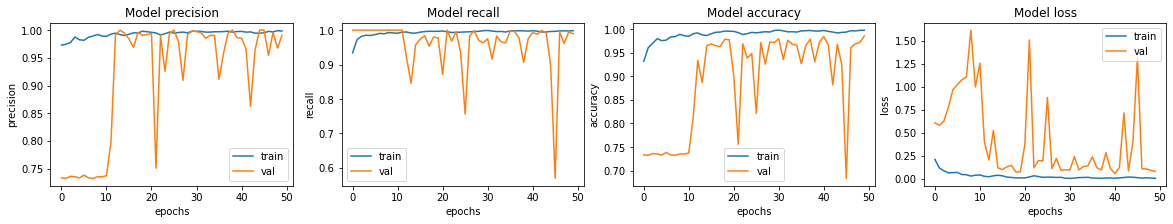

In [72]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [73]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

10/10 [==============================] - 4s 390ms/step - loss: 1.4699 - accuracy: 0.7644 - precision: 0.7288 - recall: 0.9923
Loss: 1.4699183702468872,
Accuracy: 0.7644230723381042,
Precision: 0.7288135886192322,
Recall: 0.9923076629638672


### 3. Dropout만 사용

with weights

In [74]:
with tf.device('/GPU:0'):
    model = build_drop_model()
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name = 'precision'),
        tf.keras.metrics.Recall(name = 'recall')
    ]
    
    model.compile(
        optimizer = 'Adam',
        loss = 'binary_crossentropy',
        metrics = METRICS
    )

In [75]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/50
65/65 [==============================] - 57s 743ms/step - loss: 0.6942 - accuracy: 0.4954 - precision: 0.7393 - recall: 0.4968 - val_loss: 0.6987 - val_accuracy: 0.2676 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
65/65 [==============================] - 46s 721ms/step - loss: 0.6924 - accuracy: 0.3810 - precision: 0.7294 - recall: 0.2688 - val_loss: 0.6942 - val_accuracy: 0.2676 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
65/65 [==============================] - 47s 733ms/step - loss: 0.6942 - accuracy: 0.3853 - precision: 0.7178 - recall: 0.2847 - val_loss: 0.6915 - val_accuracy: 0.7383 - val_precision: 0.7383 - val_recall: 1.0000
Epoch 4/50
65/65 [==============================] - 49s 760ms/step - loss: 0.6928 - accuracy: 0.4356 - precision: 0.7457 - recall: 0.3666 - val_loss: 0.6929 - val_accuracy: 0.7373 - val_precision: 0.7373 - val_recall: 1.0000
Epoch 5/50
65/65 [==============================] - 52s 804ms/step - loss: 0.6915 - 

65/65 [==============================] - 45s 696ms/step - loss: 0.6912 - accuracy: 0.5591 - precision: 0.7446 - recall: 0.6227 - val_loss: 0.6922 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.00000.6827 - accuracy: 0.542
Epoch 37/50
65/65 [==============================] - 44s 685ms/step - loss: 0.6943 - accuracy: 0.5077 - precision: 0.7445 - recall: 0.5131 - val_loss: 0.6960 - val_accuracy: 0.2627 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 38/50
65/65 [==============================] - 44s 688ms/step - loss: 0.6918 - accuracy: 0.4180 - precision: 0.7329 - recall: 0.3458 - val_loss: 0.6940 - val_accuracy: 0.2637 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 39/50
65/65 [==============================] - 45s 701ms/step - loss: 0.6909 - accuracy: 0.4228 - precision: 0.7482 - recall: 0.3417 - val_loss: 0.6926 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 40/50
65/65 [==============================] - 45s 691ms/step 

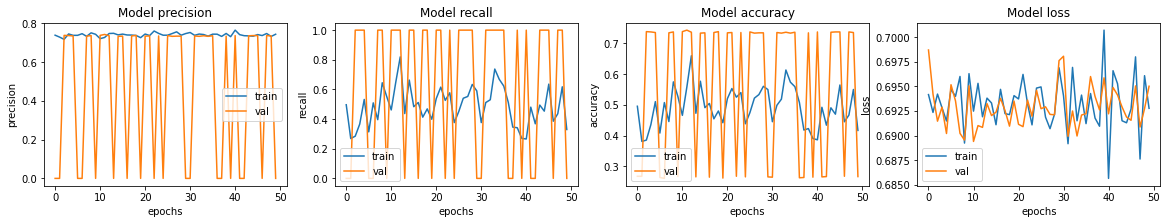

In [76]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [77]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

10/10 [==============================] - 4s 399ms/step - loss: 0.6942 - accuracy: 0.3750 - precision: 0.0000e+00 - recall: 0.0000e+00
Loss: 0.6941545009613037,
Accuracy: 0.375,
Precision: 0.0,
Recall: 0.0


without weights

In [78]:
with tf.device('/GPU:0'):
    model = build_drop_model()
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name = 'precision'),
        tf.keras.metrics.Recall(name = 'recall')
    ]
    
    model.compile(
        optimizer = 'Adam',
        loss = 'binary_crossentropy',
        metrics = METRICS
    )

In [79]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
#         class_weight=class_weight,
    )

Epoch 1/50
65/65 [==============================] - 53s 706ms/step - loss: 0.5985 - accuracy: 0.7370 - precision: 0.7441 - recall: 0.9851 - val_loss: 0.5799 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 2/50
65/65 [==============================] - 47s 722ms/step - loss: 0.5801 - accuracy: 0.7437 - precision: 0.7437 - recall: 1.0000 - val_loss: 0.5761 - val_accuracy: 0.7373 - val_precision: 0.7373 - val_recall: 1.0000
Epoch 3/50
65/65 [==============================] - 47s 737ms/step - loss: 0.5791 - accuracy: 0.7442 - precision: 0.7442 - recall: 1.0000 - val_loss: 0.5829 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 4/50
65/65 [==============================] - 49s 759ms/step - loss: 0.5753 - accuracy: 0.7454 - precision: 0.7454 - recall: 1.0000 - val_loss: 0.5811 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 5/50
65/65 [==============================] - 51s 796ms/step - loss: 0.5747 - accuracy: 0.7433

65/65 [==============================] - 45s 695ms/step - loss: 0.5728 - accuracy: 0.7423 - precision: 0.7423 - recall: 1.0000 - val_loss: 0.5759 - val_accuracy: 0.7373 - val_precision: 0.7373 - val_recall: 1.0000
Epoch 38/50
65/65 [==============================] - 44s 686ms/step - loss: 0.5699 - accuracy: 0.7442 - precision: 0.7442 - recall: 1.0000 - val_loss: 0.5780 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 39/50
65/65 [==============================] - 43s 668ms/step - loss: 0.5721 - accuracy: 0.7421 - precision: 0.7421 - recall: 1.0000 - val_loss: 0.5779 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 40/50
65/65 [==============================] - 44s 683ms/step - loss: 0.5687 - accuracy: 0.7471 - precision: 0.7471 - recall: 1.0000 - val_loss: 0.5769 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 41/50
65/65 [==============================] - 44s 687ms/step - loss: 0.5728 - accuracy: 0.7428 - prec

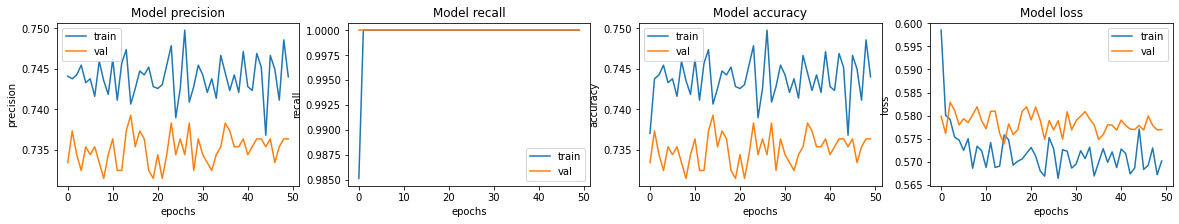

In [80]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [81]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

10/10 [==============================] - 4s 412ms/step - loss: 0.6952 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 0.6951729655265808,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


## 총 3가지 경우에 대해 weight  유뮤로 비교한 결과

1. 모델의 파라미터수를 증가시킨 1번 모델은 weight를 주지 않은 모델이 더 좋은 결과를 보인다. 이는 학습 데이터에 어느정도 과적합이 되지 않았을까 하는 의심을 할 수 있다.
2. BatchNorm만을 사용한 2번 모델에서 Weight를 준 경우의 accuracy가 85%가까이 나오면서 더 좋은 성능을 보였다. acc와 precision은 증가하였으나 recall값은 감소한 것을 볼 수 있는데, 어느정도 일반화된 모델로 생각된다.
3. Dropout만을 사용한 3번 모델은 학습이 제대로 되지 않았다.